In [97]:
#Importar librerias
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer, KBinsDiscretizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, confusion_matrix, roc_auc_score,mean_absolute_error,mean_squared_error
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV,StratifiedKFold
from math import sqrt

import time
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import gc

import seaborn as sns
#import pyodbc
import math
import os
import subprocess
from time import time
from operator import itemgetter
import pprint
seed=2106

import warnings

warnings.filterwarnings("ignore")

from scipy.stats import randint

import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go

import pickle

In [98]:
# Cargamos la data del bucket
df_income = pd.read_parquet('gs://income-bucket/01bd/08model/db_income_202107.parquet.gzip')

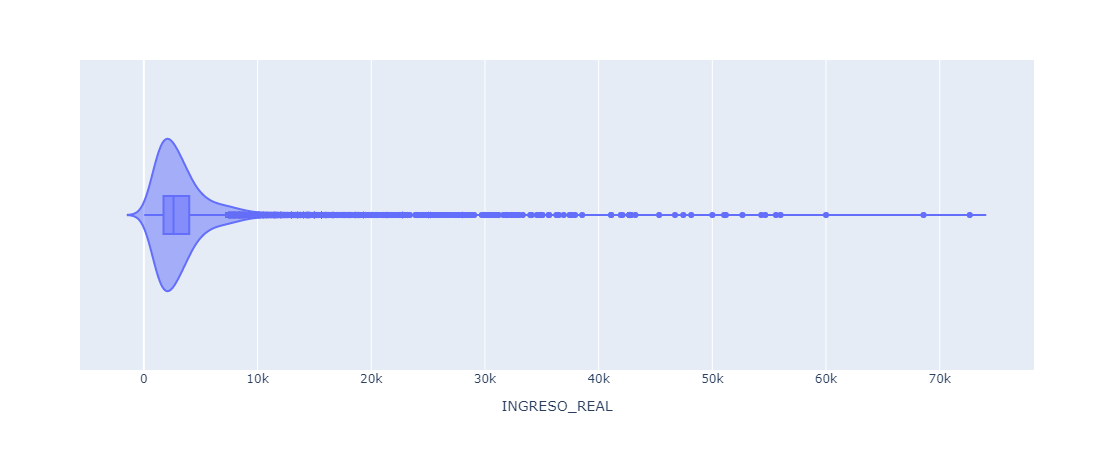

In [3]:
import plotly.express as px
fig = px.violin(df_income, x="INGRESO_REAL", box=True,)
fig

In [99]:
# Filtramos los ingresos mayores a la mitad del ingreso mínimo y menores a 10 mil soles
df_income = df_income[(df_income['INGRESO_REAL']>450)&(df_income['INGRESO_REAL']<=10000)]
# Por seguridad, aplicamos los filtros de exclusión de los outliers
df_income = df_income[(df_income['FLAG_EXCLUSION_MAX_SALDO_ENTIDAD_X_12M_ORIGEN']==0)&(df_income['FLAG_EXCLUSION_PROM_DEC_SALDO_TOTAL_12M_ORIGEN']==0)]

In [100]:
#Listamos las variables finales del modelo
feature_model = [
                'EDAD',
                'PADRON_INSTRUC',
                'SUNAT_CONDICION',
                'MAX_SALDO_ENTIDAD_X_12M_LOG',
                'PROM_DEC_SALDO_TOTAL_12M_LOG',
                'MTO_LINEA_TC_NO_UTIL_010',
                ]

In [101]:
# Definimos el target y los features
X=df_income[feature_model]
y=df_income['INGRESO_REAL']

# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y,
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [48]:
print("Partición de entrenamento")
print("-----------------------")
print(y_train.describe())

Partición de entrenamento
-----------------------
count    105800.000000
mean       3080.106930
std        1893.820410
min         451.857143
25%        1719.328826
50%        2590.000000
75%        3850.000000
max       10000.000000
Name: INGRESO_REAL, dtype: float64


In [49]:
print("Partición de entrenamento")
print("-----------------------")
print(y_test.describe())

Partición de entrenamento
-----------------------
count    26451.000000
mean      3089.896058
std       1902.881584
min        451.321429
25%       1700.000000
50%       2594.870000
75%       3850.000000
max      10000.000000
Name: INGRESO_REAL, dtype: float64


In [102]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.linear_model import Ridge

numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[
                            ('imputer', SimpleImputer(strategy='constant',fill_value=0)),
                            ('scaler', StandardScaler())
                        ]
                      )


# configuración del preprocesador 
preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                    ],
                    remainder='passthrough'
                )

pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Train
# ==============================================================================
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = pipe.fit(X=X_train, y=y_train)

In [63]:
from sklearn.model_selection import cross_val_score

# Validación cruzada repetida con múltiples métricas
# ==============================================================================
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedKFold

cv = RepeatedKFold(n_splits=3, n_repeats=5, random_state=123)
cv_scores = cross_validate(
                estimator = pipe,
                X         = X_train,
                y         = y_train,
                scoring   = ('r2', 'neg_root_mean_squared_error'),
                cv        = cv,
                return_train_score = True
            )

# Se convierte el diccionario a dataframe para facilitar la visualización
cv_scores = pd.DataFrame(cv_scores)
cv_scores

fit_time  score_time   test_r2  train_r2  \
0   0.030280    0.009597  0.175851  0.176461   
1   0.044401    0.014669  0.173750  0.177529   
2   0.044250    0.015164  0.178979  0.174955   
3   0.044294    0.014832  0.173774  0.177473   
4   0.044256    0.014229  0.176022  0.176415   
5   0.045642    0.015345  0.178585  0.175032   
6   0.045318    0.014526  0.175268  0.176791   
7   0.044010    0.013940  0.179786  0.174463   
8   0.048108    0.014625  0.173451  0.177675   
9   0.045056    0.014708  0.180741  0.174040   
10  0.043159    0.014104  0.172179  0.178287   
11  0.044247    0.014216  0.175588  0.176615   
12  0.047682    0.015016  0.174054  0.177381   
13  0.048063    0.014788  0.178894  0.174985   
14  0.046269    0.014680  0.175688  0.176568   

    test_neg_root_mean_squared_error  train_neg_root_mean_squared_error  
0                       -1729.689972                       -1713.359128  
1                       -1719.835453                       -1718.299931  
2                       -1707.082067                       -1724.626021  
3                       -1709.857621                       -1723.280358  
4                       -1718.396308                       -1718.997468  
5                       -1728.437260                       -1714.002031  
6                       -1715.668578                       -1720.351773  
7                       -1723.189625                       -1716.644338  
8                       -1717.824315                       -1719.304015  
9                       -1712.276182                       -1722.055634  
10                      -1730.031264                       -1713.196415  
11                      -1714.354383                       -1721.031276  
12                      -1726.659694                       -1714.878428  
13                      -1711.915285                       -1722.224918  
14                      -1718.020165                       -1719.203854

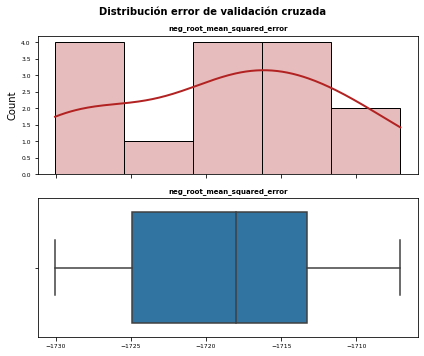

In [64]:
# Distribución del error de validación cruzada
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 5), sharex=True)

sns.histplot(
    data    = cv_scores['test_neg_root_mean_squared_error'],
    stat    = "count",
    kde     = True,
    line_kws= {'linewidth': 2},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[0]
)

axes[0].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[0].tick_params(labelsize = 6)
axes[0].set_xlabel("")
    
sns.boxplot(
    cv_scores['test_neg_root_mean_squared_error'],
    ax      = axes[1]
)
axes[1].set_title('neg_root_mean_squared_error', fontsize = 7, fontweight = "bold")
axes[1].tick_params(labelsize = 6)
axes[1].set_xlabel("")


fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución error de validación cruzada', fontsize = 10,
             fontweight = "bold");

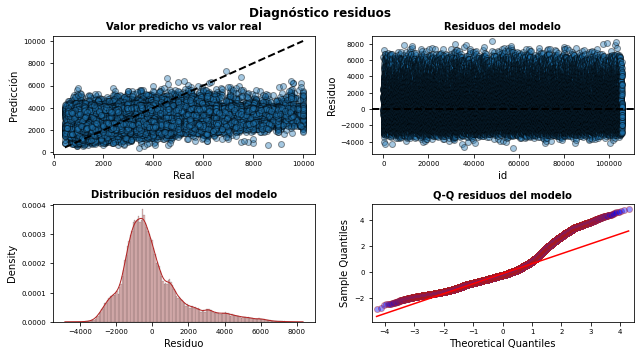

In [65]:
# Diagnóstico errores (residuos) de las predicciones de validación cruzada
# ==============================================================================
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
import statsmodels.api as sm

# Validación cruzada
# ==============================================================================
cv = KFold(n_splits=5, random_state=123, shuffle=True)
cv_prediccones = cross_val_predict(
                    estimator = pipe,
                    X         = X_train,
                    y         = y_train,
                    cv        = cv
                  )

# Gráficos
# ==============================================================================
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))

axes[0, 0].scatter(y_train, cv_prediccones, edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()],
                'k--', color = 'black', lw=2)
axes[0, 0].set_title('Valor predicho vs valor real', fontsize = 10, fontweight = "bold")
axes[0, 0].set_xlabel('Real')
axes[0, 0].set_ylabel('Predicción')
axes[0, 0].tick_params(labelsize = 7)

axes[0, 1].scatter(list(range(len(y_train))), y_train - cv_prediccones,
                   edgecolors=(0, 0, 0), alpha = 0.4)
axes[0, 1].axhline(y = 0, linestyle = '--', color = 'black', lw=2)
axes[0, 1].set_title('Residuos del modelo', fontsize = 10, fontweight = "bold")
axes[0, 1].set_xlabel('id')
axes[0, 1].set_ylabel('Residuo')
axes[0, 1].tick_params(labelsize = 7)

sns.histplot(
    data    = y_train - cv_prediccones,
    stat    = "density",
    kde     = True,
    line_kws= {'linewidth': 1},
    color   = "firebrick",
    alpha   = 0.3,
    ax      = axes[1, 0]
)

axes[1, 0].set_title('Distribución residuos del modelo', fontsize = 10,
                     fontweight = "bold")
axes[1, 0].set_xlabel("Residuo")
axes[1, 0].tick_params(labelsize = 7)


sm.qqplot(
    y_train - cv_prediccones,
    fit   = True,
    line  = 'q',
    ax    = axes[1, 1], 
    color = 'firebrick',
    alpha = 0.4,
    lw    = 2
)
axes[1, 1].set_title('Q-Q residuos del modelo', fontsize = 10, fontweight = "bold")
axes[1, 1].tick_params(labelsize = 7)

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Diagnóstico residuos', fontsize = 12, fontweight = "bold");

In [66]:
from sklearn import set_config
set_config(display='diagram')

preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('scaler', StandardScaler())]),
                                 ['MAX_SALDO_ENTIDAD_X_12M_LOG',
                                  'PROM_DEC_SALDO_TOTAL_12M_LOG',
                                  'MTO_LINEA_TC_NO_UTIL_010', 'EDAD',
                                  'PADRON_INSTRUC', 'SUNAT_CONDICION'])])

In [67]:
predicciones = pipe.predict(X_test)

In [68]:
# Se crea un dataframe con las predicciones y el valor real
df_predicciones = pd.DataFrame({'precio' : y_test, 'prediccion' : predicciones})
df_predicciones.head()

precio   prediccion
129695  1500.0  4007.123430
38727   2950.0  2814.489512
134045  2382.0  3206.317762
104035  8000.0  3342.599111
15957    930.0  2080.697187

In [69]:
# neg_root_mean_squared_error de test
# ==============================================================================
from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
rmse

1727.581946004424

In [70]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
import multiprocessing

# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {'modelo__alpha': np.logspace(-5, 3, 100)}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 5), 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

param_modelo__alpha  mean_test_score  std_test_score  mean_train_score  \
2           42.292429     -1718.923664        8.018308      -1718.770857   

   std_train_score  
2          2.00089

In [71]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.plots import plot_convergence

In [72]:
espacio_busqueda  = [Real(1e-6, 1e+3, "log-uniform", name='modelo__alpha')]

@use_named_args(espacio_busqueda)
def objective(**params):
    pipe.set_params(**params)
    return -np.mean(cross_val_score(pipe, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_root_mean_squared_error"))

resultados_opt = gp_minimize(
                    func         = objective,
                    dimensions   = espacio_busqueda,
                    n_calls      = 50,
                    random_state = 0
                )

print(f"Mejor score validación: {resultados_opt.fun}")
print(f"Mejores hiperparámetros: {list(zip([x.name for x in espacio_busqueda], resultados_opt.x))}")

Mejor score validación: 1718.937852738159
Mejores hiperparámetros: [('modelo__alpha', 85.93710791496105)]


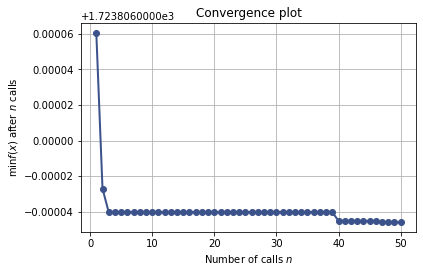

In [94]:
fig, ax = plt.subplots(figsize=(6, 3.84))
plot_convergence(resultados_opt, ax = ax);

# K-Nearest Neighbor (kNN)

In [73]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer

# Pipeline: preprocesado + modelo
# ==============================================================================

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', KNeighborsRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__n_neighbors': np.linspace(1, 100, 500, dtype=int)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 5,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

param_modelo__n_neighbors  mean_test_score  std_test_score  \
2                        64      -1468.17194       10.563925   

   mean_train_score  std_train_score  
2       -1445.23315         2.558464

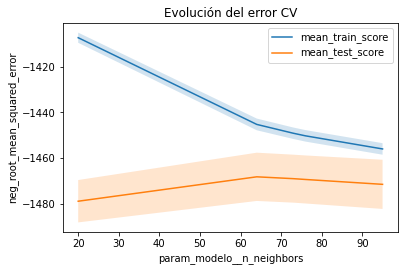

In [74]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 3.84))
hiperparametro = 'param_modelo__n_neighbors'
resultados = resultados.sort_values(hiperparametro, ascending = False)
metrica    = grid.scoring

resultados.plot(hiperparametro, 'mean_train_score', ax=ax)
resultados.plot(hiperparametro, 'mean_test_score', ax=ax)
ax.fill_between(resultados[hiperparametro].astype(np.int),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados[hiperparametro].astype(np.int),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel(metrica);

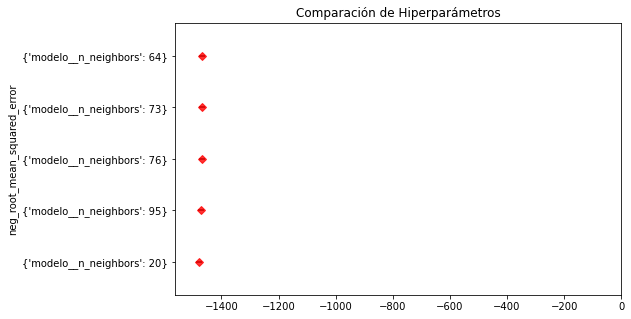

In [75]:
fig, ax = plt.subplots(figsize=(8, 5))

resultados = resultados.sort_values('mean_test_score', ascending = True)

ax.barh(
    [str(d) for d in resultados['params']],
    resultados['mean_test_score'],
    xerr=resultados['std_test_score'],
    align='center',
    alpha=0
)
ax.plot(
    resultados['mean_test_score'],
    [str(d) for d in resultados['params']],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Comparación de Hiperparámetros')
ax.set_ylabel(metrica);

In [76]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_knn = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print(f"El error (rmse) de test es: {rmse_knn}")1511

El error (rmse) de test es: 1473.0254776633658


# Árboles de decisión


In [12]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.tree import DecisionTreeRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', DecisionTreeRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__min_samples_leaf': ["auto", 3, 5, 7, 10],
                       'modelo__max_depth'   : [None, 3, 5, 10, 20]}       

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 100,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 4), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)


param_modelo__min_samples_leaf  param_modelo__max_depth  mean_test_score  \
0                              10                        3     -1518.037142   

   std_test_score  mean_train_score  std_train_score  
0        5.148035      -1501.537891         3.674123

In [13]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_dt = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_dt}")

El error (rmse) de test es: 1520.015452


# Regresión lineal (Ridge y Lasso)

In [83]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge

# Pipeline: preprocesado + modelo
# ==============================================================================

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', Ridge())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro
param_distributions = {'modelo__alpha': np.logspace(-5, 5, 500)}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 100,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 4), 
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

param_modelo__alpha  mean_test_score  std_test_score  mean_train_score  \
84           37.423663      -1718.88821       11.334222      -1718.771557   

    std_train_score  
84         2.828511

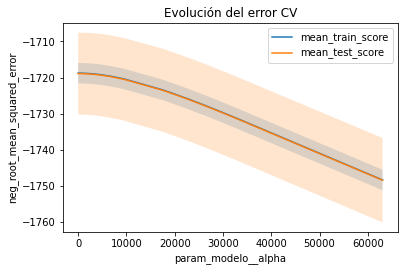

In [84]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3.84))
hiperparametro = 'param_modelo__alpha'
resultados = resultados.sort_values(hiperparametro, ascending = False)
metrica    = grid.scoring

resultados.plot(hiperparametro, 'mean_train_score', ax=ax)
resultados.plot(hiperparametro, 'mean_test_score', ax=ax)
ax.fill_between(resultados[hiperparametro].astype(np.int),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados[hiperparametro].astype(np.int),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel(metrica);

In [85]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_lm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_lm}")

El error (rmse) de test es: 1727.5825936861381


# Random Forest

In [3]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', RandomForestRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 1000, 2000],
    'modelo__max_features': ["auto", 3, 5, 7],
    'modelo__max_depth'   : [None, 3, 5, 10, 20]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 1,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 2, n_repeats = 2),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

param_modelo__n_estimators param_modelo__max_features  \
0                          50                       auto   

   param_modelo__max_depth  mean_test_score  std_test_score  mean_train_score  \
0                       20     -1454.466234        1.750212       -987.848854   

   std_train_score  
0         1.973113

In [4]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_rf = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          )
print(f"El error (rmse) de test es: {rmse_rf}")

El error (rmse) de test es: 1450.6864319269046


# Gradient Boosting Trees

In [7]:
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from sklearn.ensemble import GradientBoostingRegressor

# Pipeline: preprocesado + modelo
# ==============================================================================

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', GradientBoostingRegressor())])

# Optimización de hiperparámetros
# ==============================================================================
# Espacio de búsqueda de cada hiperparámetro

param_distributions = {
    'modelo__n_estimators': [50, 100, 1000, 2000],
    'modelo__max_features': ["auto", 3, 5, 7],
    'modelo__max_depth'   : [None, 3, 5, 10, 20],
    'modelo__subsample'   : [0.5,0.7, 1]
}

# Búsqueda random grid
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 10,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits = 5, n_repeats = 3),
        refit      = True, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(1)

param_modelo__subsample  param_modelo__n_estimators  \
0                      0.7                        1000   

   param_modelo__max_features  param_modelo__max_depth  mean_test_score  \
0                           5                        3     -1432.179898   

   std_test_score  mean_train_score  std_train_score  
0       10.899435      -1430.687281         2.646289

In [9]:
# Error de test del modelo final
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse_gbm = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
          ) 
print(f"El error (rmse) de test es: {rmse_gbm}")

El error (rmse) de test es: 1432.33775303536


In [6]:
from sklearn.metrics import r2_score
r2_gbm = r2_score(
            y_true  = y_test,
            y_pred  = predicciones,
          )
print(f"El error (rmse) de test es: {r2_gbm}")

El error (rmse) de test es: 0.4804851664021657


# Stacking

In [107]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

# Pipeline: preprocesado + modelos para el stacking
# ==============================================================================

# Se combinan los pasos de preprocesado y los modelos creando varios pipeline.
pipe_ridge = Pipeline([('preprocessing', preprocessor),
                     ('ridge', Ridge(alpha=3.4))])

pipe_rf = Pipeline([('preprocessing', preprocessor),
                     ('random_forest', RandomForestRegressor(
                                         n_estimators = 1000,
                                         max_features = 7,
                                         max_depth    = 20
                                        )
                     )])

In [10]:
# Definición y entrenamiento del StackingRegressor
# ==============================================================================
estimators = [('ridge', pipe_ridge),
              ('random_forest', pipe_rf)]

stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = stacking_regressor.fit(X = X_train, y = y_train)

In [11]:
# Error de test del stacking
# ==============================================================================
modelo_final = stacking_regressor
predicciones = modelo_final.predict(X = X_test)
rmse_stacking = mean_squared_error(
                    y_true  = y_test,
                    y_pred  = predicciones,
                    squared = False
                  )
print(f"El error (rmse) de test es: {rmse_stacking}")

El error (rmse) de test es: 1435.046284245975


# Comparación

In [22]:
#Consolidación de las simulaciones
error_modelos = pd.DataFrame({
                        'modelo': ['knn', 'lm', 'random forest', 'gradient boosting',
                                   'stacking'],
                        'rmse': [rmse_dt,rmse_knn, rmse_lm, rmse_rf, rmse_gbm, rmse_stacking]
                     })
error_modelos = error_modelos.sort_values('rmse', ascending=False)


In [24]:
import plotly.express as px
fig = px.violin(error_modelos, x="modelo",y='rmse', color="modelo", box=True, points="all")
fig

In [42]:
def upload_blob(bucket_name, pickle, destination_blob_name,source_file_name):
    """Cargar archivos al bucket de GCP.
    input:
        bucket_name : "your-bucket-name" El ID del GCS bucket
        source_file_name : "local/path/to/file" Directorio del archivo a cargar
        destination_blob_name : "storage-object-name" El ID del objeto en GCS
    """
    import os
    from google.cloud import storage
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name + source_file_name)
    blob.upload_from_string(pickle, source_file_name)
    print("File {} uploaded to {}.".format(source_file_name, destination_blob_name + source_file_name))

In [106]:
#Se almacena el modelo elegigo para la puesta en producción
import pickle
model_pickle = pickle.dumps(modelo_final)
upload_blob("income-bucket", model_pickle, "01bd/09production/", "model.pkl")

File model.pkl uploaded to 01bd/09production/model.pkl.
